<div align="center" dir="auto">
<p dir="auto">

<a href="https://colab.research.google.com/github/write-with-neurl/modelbit-09/blob/main/notebook/Deploying_DINOv2_for_Image_Classification_with_Modelbit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

</p>

# ⚡ Deploying DINOv2 to A Rest API Endpoint for Image Classification | Modelbit



This demo focuses on leveraging DINOv2 for image classification. If you are interested in DINOv2's additional use cases and capabilities, check out the links below.

*   [DINOv2 GitHub Repo](https://github.com/facebookresearch/dinov2)
*   [Meta AI's DINOv2 Blog Post](https://ai.meta.com/blog/dino-v2-computer-vision-self-supervised-learning/)
* [Meta DINOv2 Demos](https://dinov2.metademolab.com)
* [DINOv2 Paper](https://arxiv.org/pdf/2304.07193.pdf)

## 🏠 Testing Locally
Before deploying, it's always good practice to test things locally! In this section, we'll focus on setting up our environment and using this model locally before deployment.

In [ ]:
!apt update && apt upgrade -y && apt autoremove -y
!pip3 install --upgrade pip setuptools wheel
!pip3 install --upgrade --no-cache-dir --extra-index-url https://pypi.nvidia.com cuml-cu11
!pip3 install --upgrade --no-cache-dir --extra-index-url https://pypi.nvidia.com --extra-index-url https://download.pytorch.org/whl/cu117 git+https://github.com/facebookresearch/dinov2.git modelbit

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 229 kB in 2s (118 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
4 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency

### 🔃 Download and Load DINOv2 Weights into Memory



Import the necessary dependencies required to run the demo. Then, load the DINOv2 weights. Depending on how much VRAM you have, choose the size of your weights carefully.

For free Colab notebooks, you can utilize the T4 GPUs which provide 16gb of VRAM. This means you should be able to load any of the mentioned weights in the DINOv2 repository. You can change your runtime context on the top right corner of Colab.

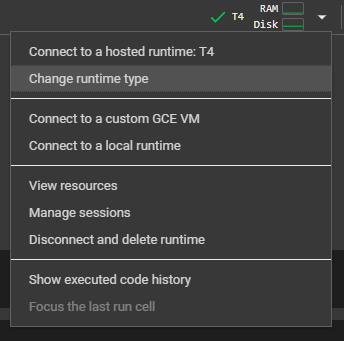

* To determine the size of weights you can load into DINOv2, view this table [here](https://github.com/facebookresearch/dinov2#pretrained-models).

* To view the current names of each class size for image classification, click [here](https://github.com/facebookresearch/dinov2#pretrained-heads---image-classification).

In [ ]:
import torch
import torchvision.transforms as T
import json
import urllib
import requests
from PIL import Image
from io import BytesIO

# Get ImageNet labels
imagenet_class_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
imagenet_classes = json.loads(urllib.request.urlopen(imagenet_class_url).read())

# Set a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the DINOv2 model
# dinov2_vitg14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg_lc').eval().to(device)
dinov2_vitg14_reg_lc = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg_lc').eval().to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_reg4_pretrain.pth
100%|██████████| 330M/330M [00:02<00:00, 119MB/s]
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_linear4_head.pth" to /root/.cache/torch/hub/checkpoints/di

### 🧪 Test DINOv2 Locally with a Sample Image



Now that you have loaded the DINOv2 weights, we can pass a preprocessed image to the model. To do this, simply use `wget` or upload an image already on your machine to your Colab directory.

In [ ]:
!wget -O golden_retriever.jpg https://www.princeton.edu/sites/default/files/styles/crop_2048_ipad/public/images/2022/02/KOA_Nassau_2697x1517.jpg?itok=AuZckGYV

--2023-12-16 09:25:46--  https://www.princeton.edu/sites/default/files/styles/crop_2048_ipad/public/images/2022/02/KOA_Nassau_2697x1517.jpg?itok=AuZckGYV
Resolving www.princeton.edu (www.princeton.edu)... 104.18.5.101, 104.18.4.101, 2606:4700::6812:565, ...
Connecting to www.princeton.edu (www.princeton.edu)|104.18.5.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231798 (226K) [image/jpeg]
Saving to: ‘golden_retriever.jpg’

golden_retriever.jp 100%[===================>] 226.37K   460KB/s    in 0.5s    

2023-12-16 09:25:48 (460 KB/s) - ‘golden_retriever.jpg’ saved [231798/231798]



Next, you'll want to preprocess the image for DINOv2. Since the model was pretrained with ImageNet, we are using ImageNet preprocessing on the image.

In [ ]:
image = Image.open('golden_retriever.jpg')

transform = T.Compose([
    T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

image = transform(image).to(device)

Now, we can pass the image through out model and get a class ID and label.

In [ ]:
with torch.no_grad():
    features = dinov2_vitg14_reg_lc(image.unsqueeze(0))

print(imagenet_classes[features.argmax(-1).item()])

Golden Retriever


### ✅ Prepare a DINOv2 Image Classification Function



Before we upload our working code to Modelbit, we need to wrap all inference-related lines of code into a function. Then, we'll add code to accept an image via a URL and return a response from our API.

Below, we define a function aptly named `dinov2_classifier()`. We have designed this function to accept a URL, called `img_url`, as a string. This URL points to the image we want to classify. Once the transcription process finishes, the function returns a JSON object with the results.


In [ ]:
def dinov2_classifier(img_url):
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content))

    # Preprocess the image
    transform = T.Compose([
        T.Resize(256, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    image = transform(image)

    # Move the image to the GPU if available
    image = image.to(device)

    # Extract the features
    with torch.no_grad():
        features = dinov2_vitg14_reg_lc(image.unsqueeze(0))

    # Print the features
    return {'index': features.argmax(-1).item(),
            'label': imagenet_classes[features.argmax(-1).item()]
    }

We can now test locally since we've contained our inference code into a function. Simply pass in a URL into `dinov2_classifier()`.

Feel free to choose any image online from the [ImageNet Classes](https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json).

In [ ]:
dinov2_classifier('https://www.akc.org/wp-content/uploads/2020/07/Golden-Retriever-puppy-standing-outdoors.jpg')

{'index': 207, 'label': 'Golden Retriever'}

## 🚀 Deploying Whisper to a REST API Endpoint

Now that we've verified it works locally, it's time to see how easy it is to take our code and deploy directly to Modelbit with minimal lines of code.

### 🔐 Log into `modelbit`

Use the [`modelbit`](https://doc.modelbit.com/deployments/) library for model deployment and management. Modelbit offers you a flexible approach to [deploy ML models](https://www.modelbit.com/product/deploy-from-anywhere) from your Colab or Jupyter notebooks, or any Python environment, to production environments with REST APIs. With fully custom Python environments. Backed by your git repo.

In [ ]:
import modelbit

# Log into the 'modelbit' service using the development ("dev") branch
# Ensure you create a "dev" branch in Modelbit or use the "main" branch for your deployment
mb = modelbit.login(branch="dev")

### 📦 Deploying to Modelbit
Calling the `mb.deploy()` API will run the following for you under-the-hood:

- **Push** the source code to your Modelbit workspace.

- **Pickle the variables in the dev environment**: Your function's variables are pickled, i.e., serialized into a format that can be stored and reconstructed.

- **Detect the dependencies:** Unlike traditional deployment strategies that require manual tracking of dependencies, ModelBit intelligently detects which dependencies, libraries, and data your application needs.

- **Containerize the model weights and other helper files:** It then automatically incorporates these into the container it builds, significantly reducing the possibility of errors and saving deployment time.

- **Spin up a REST API endpoint**: After containerizing your model and it’s dependencies, Modelbit replicates the environment in production for consistency and spins up a REST endpoint.

In the event [`mb.deploy()`](https://doc.modelbit.com/api-reference/deploy/) misses any packages, you there are additional flags you can pass.

For more information regarding environment customization, click [here](https://doc.modelbit.com/deployments/custom-python-environments/).

In our deployment below, we also want to deploy to Modelbit with a GPU on the inference server. This can either be enabled on Modelbit's dashboard or within `mb.deploy()` at any time.



In [ ]:
mb.deploy(dinov2_classifier, require_gpu=True)

Uploading 'device': 100%|██████████| 64.0/64.0 [00:02<00:00, 29.0B/s]
Uploading 'dinov2_vitg14_reg_lc': 100%|██████████| 336M/336M [00:10<00:00, 32.4MB/s]


Hotfix: Next, you might notice there's an issue building the environment on Modelbit. This is due to the following lines in the `requirements.txt` not able to be installed at the initial deployment:
```
--extra-index-url https://pypi.nvidia.com
cuml-cu11
```

To add these requirements once again, we'll mirror the Modelbit deployment to a Github repo. Click on the gear cog on the top right, go to `Git Settings`. In the `Connect to your git repo` section, click on GitHub and proceed with following the instructions there.

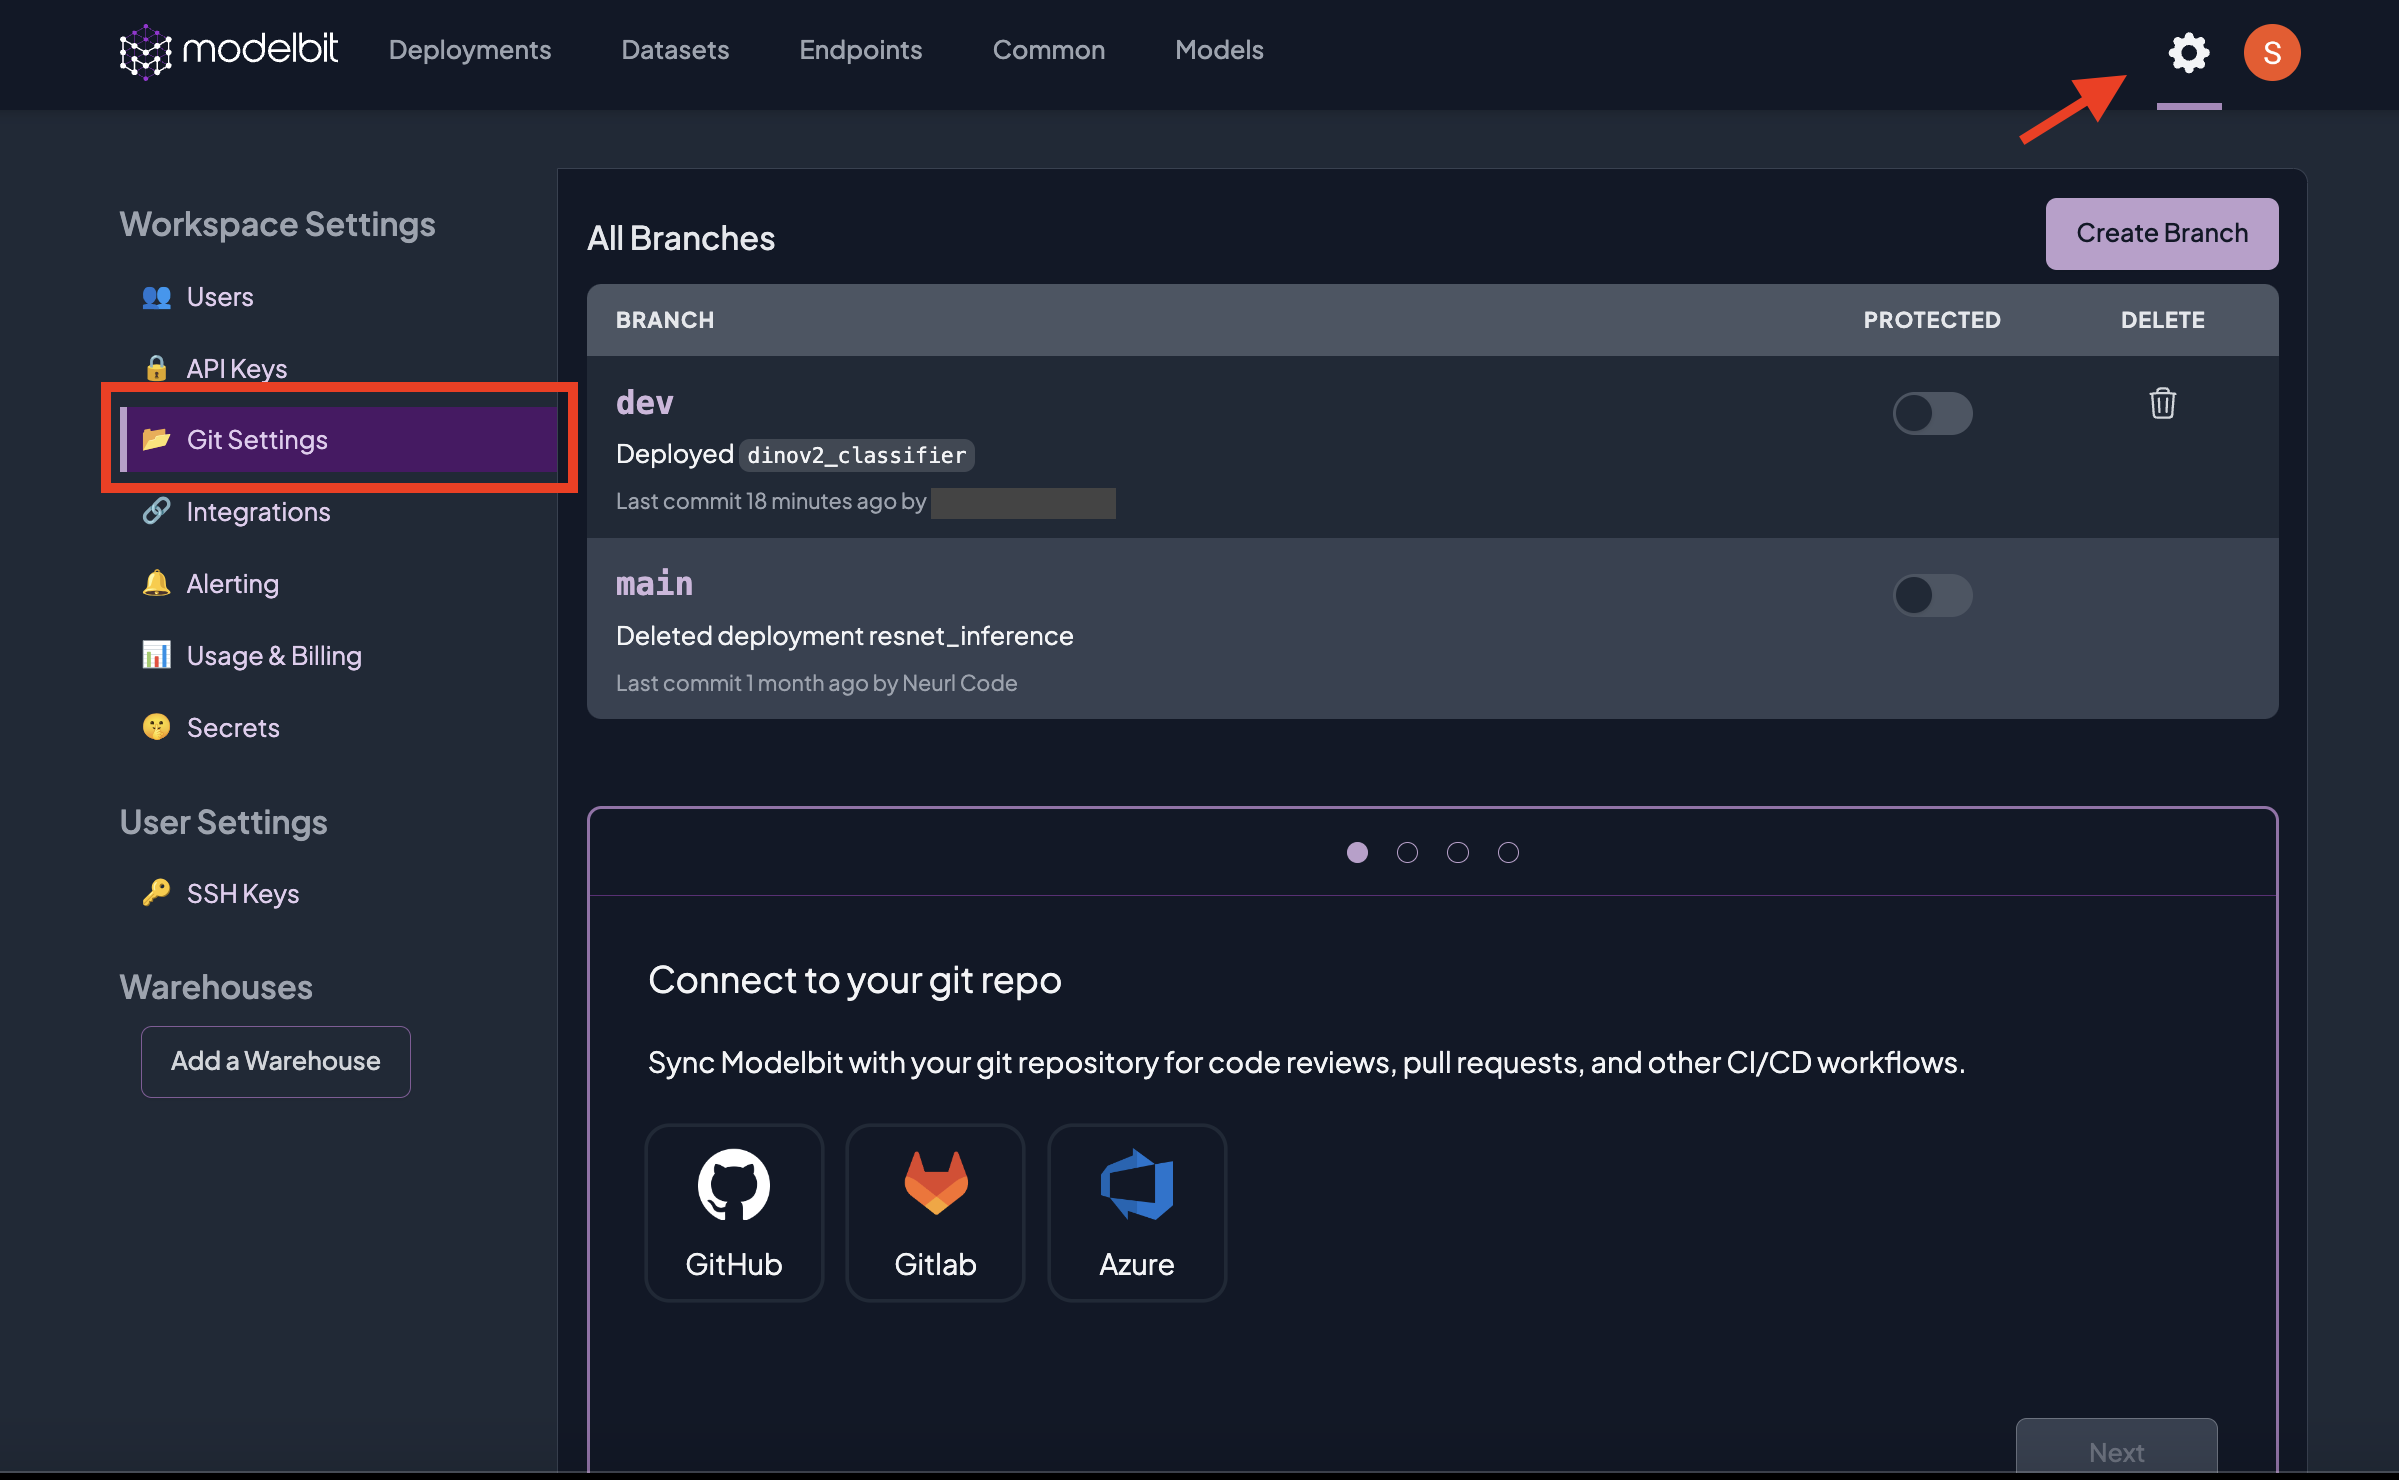


Once you complete the instructions, your GitHub repo is now synced with Modelbit. Now, any changes made to your direct GitHub repo will reflect in Modelbit. Add the two missing requirements in your GitHub repo's `requirements.txt` and wait for Modelbit to automatically redeploy. This can be done directly by editing the `requirements.txt` file directly from the GitHub website.

⚠️Note: If you want to switch your Modelbit-linked repo to another GitHub repo, make sure to delete the deploy keys before deleting the repo.

## 📩 Test the REST Endpoint with an image URL



Test your endpoint from the command line using:

> ⚠️ Replace the `ENTER_WORKSPACE_NAME` placeholder with your workspace name.
You can also test your REST Endpoint by [sending single or batch requests](https://doc.modelbit.com/deployments/rest-api/single-inference) to it for transcription.

In [ ]:
!curl -X POST "https://ENTER_WORKSPACE_NAME.app.modelbit.com/v1/dinov2_classifier/dev/latest" -d '{"data": "https://www.akc.org/wp-content/uploads/2020/07/Golden-Retriever-puppy-standing-outdoors.jpg"}'

{"data":{"index":207,"label":"Golden Retriever"}}

Use the `requests` package to POST a request to the API and use `json` to format the response to print nicely:

> ⚠️ Replace the `ENTER_WORKSPACE_NAME` placeholder with your workspace name.

In [ ]:
import json

requests.post("https://ENTER_WORKSPACE_NAME.app.modelbit.com/v1/dinov2_classifier/dev/latest",
              headers={"Content-Type":"application/json"},
              data=json.dumps({"data": "https://www.akc.org/wp-content/uploads/2020/07/Golden-Retriever-puppy-standing-outdoors.jpg"})).json()


#🥳 Congratulations on your successful deployment!

# 📚 Modelbit Documentation Tutorials

Enjoyed this walkthrough? Check out articles with similar walkthroughs:

- [Deploying a Grounding DINO Model to a REST API Endpoint for Open-Set Object Detection with Prompts](https://www.modelbit.com/blog/deploying-grounding-dino-model-to-a-rest-api-endpoint-for-open-set-object-detection-with-prompts)

- [Deploying a Segment-Anything Image Recognition Model to a REST Endpoint](https://www.modelbit.com/blog/deploying-a-segment-anything-image-recognition-model-to-a-rest-endpoint)